In [3]:
!pip install -q imbalanced-learn
!pip install -q seaborn
!pip install -q xgboost
!pip install -q lightgbm
!pip install -q catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv("/content/Bank_Transaction_Fraud_Detection.csv")
df.head()


,Customer_ID,Customer_Name,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,...,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Customer_Contact,Transaction_Description,Customer_Email
0,d5f6ec07-d69e-4f47-b9b4-7c58ff17c19e,Osha Tella,Male,60,Kerala,Thiruvananthapuram,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,...,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0.0,INR,+9198579XXXXXX,Bitcoin transaction,oshaXXXXX@XXXXX.com
1,7c14ad51-781a-4db9-b7bd-67439c175262,Hredhaan Khosla,Female,51,Maharashtra,Nashik,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,...,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0.0,INR,+9191074XXXXXX,Grocery delivery,hredhaanXXXX@XXXXXX.com
2,3a73a0e5-d4da-45aa-85f3-528413900a35,Ekani Nazareth,Male,20,Bihar,Bhagalpur,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,...,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0.0,INR,+9197745XXXXXX,Mutual fund investment,ekaniXXX@XXXXXX.com
3,7902f4ef-9050-4a79-857d-9c2ea3181940,Yamini Ramachandran,Female,57,Tamil Nadu,Chennai,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,...,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0.0,INR,+9195889XXXXXX,Food delivery,yaminiXXXXX@XXXXXXX.com
4,3a4bba70-d9a9-4c5f-8b92-1735fd8c19e9,Kritika Rege,Female,43,Punjab,Amritsar,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,...,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0.0,INR,+9195316XXXXXX,Debt repayment,kritikaXXXX@XXXXXX.com


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36849 entries, 0 to 36848
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Customer_ID              36849 non-null  object 
 1   Customer_Name            36849 non-null  object 
 2   Gender                   36849 non-null  object 
 3   Age                      36849 non-null  int64  
 4   State                    36849 non-null  object 
 5   City                     36849 non-null  object 
 6   Bank_Branch              36849 non-null  object 
 7   Account_Type             36849 non-null  object 
 8   Transaction_ID           36849 non-null  object 
 9   Transaction_Date         36849 non-null  object 
 10  Transaction_Time         36848 non-null  object 
 11  Transaction_Amount       36848 non-null  float64
 12  Merchant_ID              36848 non-null  object 
 13  Transaction_Type         36848 non-null  object 
 14  Merchant_Category     

<ipython-input-6-2615326099>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Is_Fraud', palette=palette)


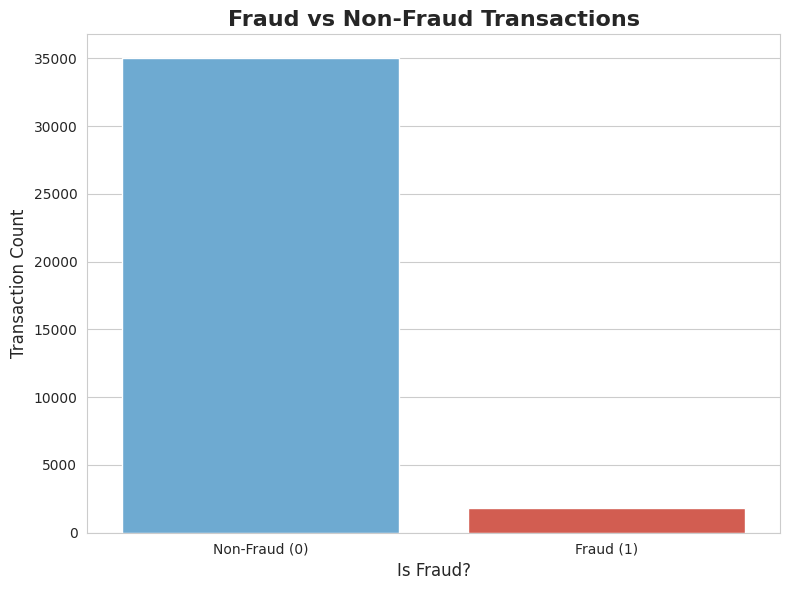

Is_Fraud
0.0    0.950174
1.0    0.049826
Name: proportion, dtype: float64


In [6]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
palette = ['#5DADE2', '#E74C3C']  # mavi ve kırmızı

sns.countplot(data=df, x='Is_Fraud', palette=palette)
plt.title('Fraud vs Non-Fraud Transactions', fontsize=16, weight='bold')
plt.xlabel('Is Fraud?', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

fraud_ratio = df['Is_Fraud'].value_counts(normalize=True)
print(fraud_ratio)


In [7]:
df_cleaned = df.drop([
    'Customer_ID', 'Customer_Name', 'Transaction_ID', 'Merchant_ID','Transaction_Currency',
    'Transaction_Date', 'Transaction_Time',
    'Transaction_Description', 'Customer_Contact', 'Customer_Email'
], axis=1)


In [8]:
# Her kategorik sütunun kaç farklı değeri var
categorical_cols = df_cleaned.select_dtypes(include='object').columns
unique_counts = df_cleaned[categorical_cols].nunique().sort_values(ascending=False)
print(unique_counts)


Transaction_Location    148
City                    145
Bank_Branch             145
State                    34
Transaction_Device       20
Merchant_Category         6
Transaction_Type          5
Device_Type               4
Account_Type              3
Gender                    2
dtype: int64


In [9]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# One-hot encode edilecek sütunlar (az kategorili, sıralı anlam taşımayan)
one_hot_cols = ['Merchant_Category', 'Transaction_Type', 'Device_Type', 'Account_Type', 'Gender']
df_cleaned = pd.get_dummies(df_cleaned, columns=one_hot_cols, drop_first=True)

# Label encode edilecek sütunlar (kategorik ama çok sınıfı olmayan)
label_encode_cols = ['Transaction_Device', 'State']
label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# Embedding için encode edilecek sütunlar (çok sayıda sınıfa sahip)
embedding_cols = ['Transaction_Location', 'Bank_Branch', 'City']
embedding_encoders = {}
for col in embedding_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    embedding_encoders[col] = le



In [10]:
scaler = StandardScaler()
numeric_cols = ['Age', 'Transaction_Amount', 'Account_Balance']
df_cleaned[numeric_cols] = scaler.fit_transform(df_cleaned[numeric_cols])


In [11]:
df_cleaned = df_cleaned.dropna(subset=['Is_Fraud'])
X = df_cleaned.drop('Is_Fraud', axis=1)
y = df_cleaned['Is_Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [12]:
X_train

,Age,State,City,Bank_Branch,Transaction_Amount,Account_Balance,Transaction_Device,Transaction_Location,Merchant_Category_Electronics,Merchant_Category_Entertainment,...,Transaction_Type_Credit,Transaction_Type_Debit,Transaction_Type_Transfer,Transaction_Type_Withdrawal,Device_Type_Desktop,Device_Type_Mobile,Device_Type_POS,Account_Type_Checking,Account_Type_Savings,Gender_Male
13941,-0.781716,3,30,30,0.325204,-1.163297,4,32,False,False,...,True,False,False,False,False,True,False,True,False,False
28186,1.700713,28,131,131,-1.638256,1.049325,19,133,False,False,...,False,True,False,False,False,False,False,False,False,True
10606,1.243423,28,117,117,0.897524,-0.108277,11,119,False,False,...,False,False,True,False,False,False,True,False,True,True
2599,0.720807,12,78,78,-0.294384,1.725256,10,80,False,False,...,False,False,False,False,False,True,False,False,True,False
7011,0.002209,15,130,130,0.008896,0.181127,1,132,True,False,...,False,False,False,True,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5509,0.916788,6,17,17,-1.663190,0.432566,18,17,False,False,...,False,False,True,False,False,False,False,True,False,False
11714,-1.108351,16,68,68,0.763669,1.494324,1,70,False,False,...,False,False,False,True,False,True,False,False,False,False
20837,-0.716389,22,32,32,-1.412322,0.792120,13,34,True,False,...,False,False,False,True,False,True,False,True,False,False
10949,-0.259099,3,30,30,1.115510,0.020399,7,32,False,False,...,True,False,False,False,False,False,False,True,False,False


In [13]:
def apply_resampling(method, X, y):
    X_res, y_res = method.fit_resample(X, y)

    # y_res'i pandas Series yap ve etiketleri adlandır
    y_res_series = pd.Series(y_res, name='Is_Fraud')
    y_res_series = y_res_series.map({0: 'Non-Fraud', 1: 'Fraud'})

    # Şık görselleştirme
    plt.figure(figsize=(8, 6))
    sns.set_style("whitegrid")
    palette = ['#3498DB', '#E74C3C']  # Mavi: Non-Fraud, Kırmızı: Fraud

    sns.countplot(x=y_res_series, palette=palette)
    plt.title(f'🧪 Distribution After Resampling with {method.__class__.__name__}', fontsize=16, weight='bold')
    plt.xlabel('Transaction Class', fontsize=12)
    plt.ylabel('Sample Count', fontsize=12)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

    return X_res, y_res


🔄 SMOTE


<ipython-input-13-1154257645>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_series, palette=palette)
<ipython-input-13-1154257645>:19: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


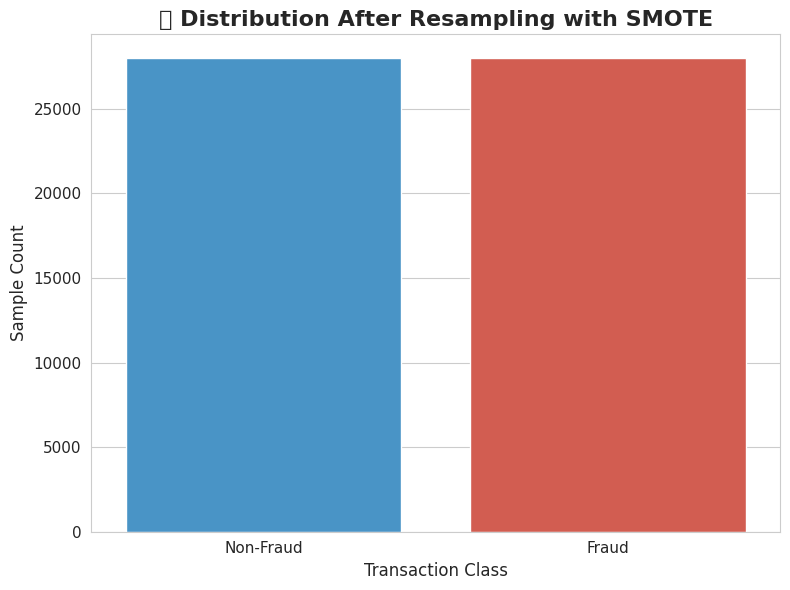

🔄 ADASYN


<ipython-input-13-1154257645>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_series, palette=palette)
<ipython-input-13-1154257645>:19: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


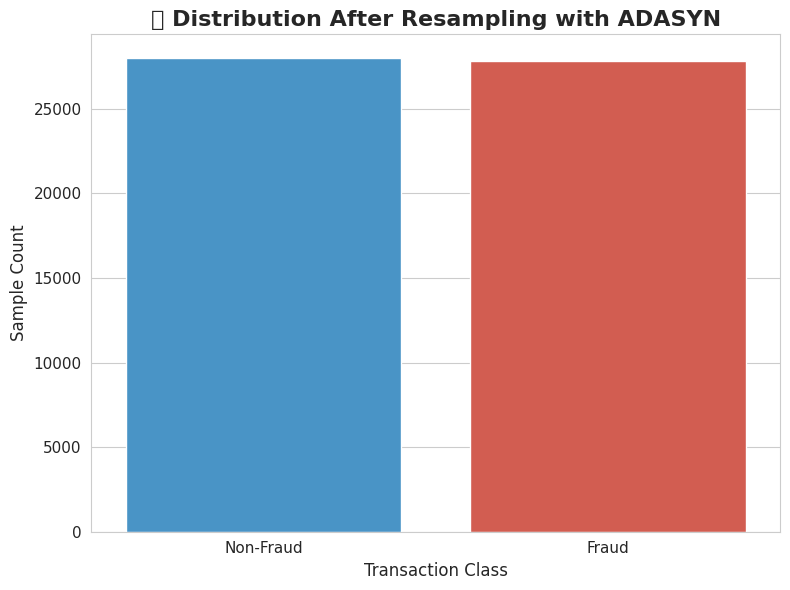

🔄 NearMiss


<ipython-input-13-1154257645>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_res_series, palette=palette)
<ipython-input-13-1154257645>:19: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


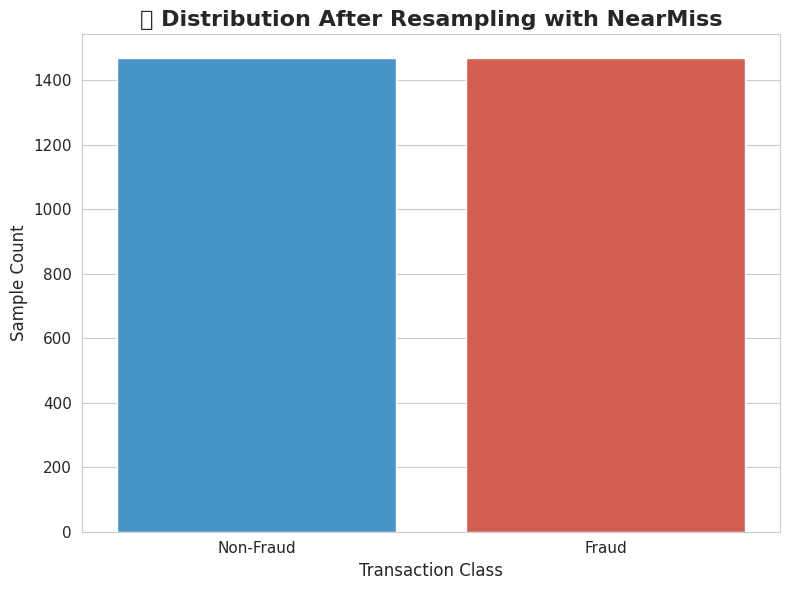

In [14]:
# SMOTE
print("🔄 SMOTE")
smote = SMOTE(random_state=42)
X_smote, y_smote = apply_resampling(smote, X_train, y_train)

# ADASYN
print("🔄 ADASYN")
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = apply_resampling(adasyn, X_train, y_train)

# NearMiss
print("🔄 NearMiss")
nearmiss = NearMiss()
X_nearmiss, y_nearmiss = apply_resampling(nearmiss, X_train, y_train)


In [15]:
# Türkçe font ayarları
plt.rcParams['font.family'] = ['DejaVu Sans']
plt.style.use('seaborn-v0_8')

In [16]:
def evaluate_models_comprehensive(X_train, y_train, X_test, y_test, method_name=""):
    """Kapsamlı model değerlendirme fonksiyonu"""
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "RandomForest": RandomForestClassifier(random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "KNN": KNeighborsClassifier(),
        "SVC": SVC(probability=True, random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "LightGBM": LGBMClassifier(random_state=42, verbose=-1),
        "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
        "GradientBoosting": GradientBoostingClassifier(random_state=42),
        "ExtraTrees": ExtraTreesClassifier(random_state=42),
        "NaiveBayes": GaussianNB()
    }

    results = []
    confusion_matrices = {}

    print(f"\n{'='*60}")
    print(f"🚀 {method_name} - MODEL EĞİTİMİ VE DEĞERLENDİRME")
    print(f"{'='*60}")

    for name, model in models.items():
        print(f"\n🔎 {name} eğitiliyor...")

        try:
            # Model eğitimi
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Olasılık tahminleri
            try:
                y_proba = model.predict_proba(X_test)[:, 1]
            except:
                y_proba = y_pred

            # Metrik hesaplamaları
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            pr_auc = auc(recall, precision)
            roc_auc = roc_auc_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            precision_val = precision_score(y_test, y_pred, zero_division=0)
            recall_val = recall_score(y_test, y_pred, zero_division=0)

            # Confusion Matrix
            cm = confusion_matrix(y_test, y_pred)
            confusion_matrices[name] = cm

            # Specificity (True Negative Rate) hesaplama
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            results.append({
                "Method": method_name,
                "Model": name,
                "Accuracy": round(acc, 4),
                "Precision": round(precision_val, 4),
                "Recall": round(recall_val, 4),
                "F1_Score": round(f1, 4),
                "Specificity": round(specificity, 4),
                "ROC_AUC": round(roc_auc, 4),
                "PR_AUC": round(pr_auc, 4),
                "True_Positives": int(tp),
                "True_Negatives": int(tn),
                "False_Positives": int(fp),
                "False_Negatives": int(fn)
            })

            print(f"   ✅ {name}: F1={f1:.4f}, Accuracy={acc:.4f}, ROC_AUC={roc_auc:.4f}")

        except Exception as e:
            print(f"   ❌ {name}: Hata - {str(e)}")
            continue

    return pd.DataFrame(results), confusion_matrices


In [17]:
def create_comprehensive_visualizations(df_results, confusion_matrices, method_name=""):
    """Kapsamlı görselleştirme fonksiyonu"""

    # 1. Metrik Karşılaştırma Tablosu
    print(f"\n📊 {method_name} - DETAYLI METRİK TABLOSU")
    print("="*120)
    display_df = df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Specificity', 'ROC_AUC', 'PR_AUC']]
    print(display_df.to_string(index=False))

    # 2. En iyi modelleri belirleme
    best_models = {
        'Accuracy': df_results.loc[df_results['Accuracy'].idxmax()],
        'F1_Score': df_results.loc[df_results['F1_Score'].idxmax()],
        'ROC_AUC': df_results.loc[df_results['ROC_AUC'].idxmax()],
        'Precision': df_results.loc[df_results['Precision'].idxmax()],
        'Recall': df_results.loc[df_results['Recall'].idxmax()]
    }

    print(f"\n🏆 {method_name} - EN İYİ MODELLER")
    print("-"*50)
    for metric, model_info in best_models.items():
        print(f"{metric:12}: {model_info['Model']:18} ({model_info[metric]:.4f})")

    # Görselleştirmeler
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle(f'{method_name} - Kapsamlı Model Analizi', fontsize=16, fontweight='bold')

    # 1. Tüm Metriklerin Karşılaştırması (Heatmap)
    ax1 = plt.subplot(2, 3, 1)
    metrics_df = df_results[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'PR_AUC']].set_index('Model')
    sns.heatmap(metrics_df.T, annot=True, cmap='RdYlBu_r', center=0.5, fmt='.3f', ax=ax1)
    ax1.set_title('🔥 Tüm Metriklerin Heatmap Karşılaştırması', fontweight='bold')
    ax1.set_xlabel('')

    # 2. F1 Score Karşılaştırması
    ax2 = plt.subplot(2, 3, 2)
    df_sorted = df_results.sort_values('F1_Score', ascending=True)
    bars = ax2.barh(df_sorted['Model'], df_sorted['F1_Score'], color='skyblue', edgecolor='navy')
    ax2.set_title('🎯 F1 Score Karşılaştırması', fontweight='bold')
    ax2.set_xlabel('F1 Score')
    # Değerleri çubukların üzerine yazma
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    # 3. Accuracy vs F1 Score Scatter
    ax3 = plt.subplot(2, 3, 3)
    scatter = ax3.scatter(df_results['Accuracy'], df_results['F1_Score'],
                         s=100, c=df_results['ROC_AUC'], cmap='viridis', alpha=0.7)
    ax3.set_xlabel('Accuracy')
    ax3.set_ylabel('F1 Score')
    ax3.set_title('📈 Accuracy vs F1 Score (ROC_AUC ile renklendirilmiş)', fontweight='bold')
    plt.colorbar(scatter, ax=ax3, label='ROC_AUC')

    # Model isimlerini noktalara ekleme
    for i, model in enumerate(df_results['Model']):
        ax3.annotate(model, (df_results['Accuracy'].iloc[i], df_results['F1_Score'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    # 4. Precision vs Recall
    ax4 = plt.subplot(2, 3, 4)
    ax4.scatter(df_results['Recall'], df_results['Precision'], s=100, alpha=0.7, c='coral')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('🎪 Precision vs Recall', fontweight='bold')
    ax4.grid(True, alpha=0.3)

    for i, model in enumerate(df_results['Model']):
        ax4.annotate(model, (df_results['Recall'].iloc[i], df_results['Precision'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

    # 5. Radar Chart (En iyi 5 model)
    ax5 = plt.subplot(2, 3, 5, projection='polar')

    top_5_models = df_results.nlargest(5, 'F1_Score')
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']

    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]

    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, (idx, row) in enumerate(top_5_models.iterrows()):
        values = [row[metric] for metric in metrics]
        values += values[:1]
        ax5.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[i])
        ax5.fill(angles, values, alpha=0.25, color=colors[i])

    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('🕸 En İyi 5 Model Radar Grafiği', fontweight='bold', pad=20)
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # 6. Model Performans Özeti (Bar Chart)
    ax6 = plt.subplot(2, 3, 6)
    x = np.arange(len(df_results))
    width = 0.15

    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']

    for i, metric in enumerate(metrics_to_plot):
        ax6.bar(x + i*width, df_results[metric], width, label=metric, color=colors[i], alpha=0.8)

    ax6.set_xlabel('Modeller')
    ax6.set_ylabel('Score')
    ax6.set_title('📊 Temel Metriklerin Karşılaştırması', fontweight='bold')
    ax6.set_xticks(x + width * 1.5)
    ax6.set_xticklabels(df_results['Model'], rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Confusion Matrix Görselleştirmeleri (Ayrı bir figure)
    n_models = len(confusion_matrices)
    cols = 4
    rows = (n_models + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    fig.suptitle(f'{method_name} - Confusion Matrix Karşılaştırması', fontsize=14, fontweight='bold')

    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)

    for i, (model_name, cm) in enumerate(confusion_matrices.items()):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f'{model_name}', fontweight='bold')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # Boş subplotları gizle
    for i in range(n_models, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [18]:
def compare_all_methods(results_dict):
    """Tüm yöntemleri karşılaştırma fonksiyonu"""

    # Tüm sonuçları birleştir
    all_results = []
    for method, df in results_dict.items():
        df_copy = df.copy()
        df_copy['Method'] = method
        all_results.append(df_copy)

    combined_df = pd.concat(all_results, ignore_index=True)

    print("\n" + "="*100)
    print("🔥 TÜM YÖNTEMLERİN KAPSAMLI KARŞILAŞTIRMASI")
    print("="*100)

    # Her metrik için en iyi performansı gösteren yöntem ve model
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'PR_AUC']

    print(f"\n🏆 EN İYİ PERFORMANSLAR:")
    print("-"*80)
    for metric in metrics:
        best_row = combined_df.loc[combined_df[metric].idxmax()]
        print(f"{metric:12}: {best_row['Method']:15} - {best_row['Model']:18} ({best_row[metric]:.4f})")

    # Yöntem bazında ortalama performanslar
    method_avg = combined_df.groupby('Method')[metrics].mean()
    print(f"\n📊 YÖNTEM BAZINDA ORTALAMA PERFORMANSLAR:")
    print("-"*80)
    print(method_avg.round(4).to_string())

    # Görselleştirme
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🚀 Tüm Yöntemlerin Detaylı Karşılaştırması', fontsize=16, fontweight='bold')

    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        pivot_df = combined_df.pivot_table(values=metric, index='Model', columns='Method', aggfunc='mean')

        ax = axes[i]
        sns.heatmap(pivot_df, annot=True, cmap='RdYlBu_r', fmt='.3f', ax=ax)
        ax.set_title(f'{metric} Karşılaştırması', fontweight='bold')
        ax.set_xlabel('Balancing Method')
        ax.set_ylabel('Model')

    plt.tight_layout()
    plt.show()

    # En iyi model-yöntem kombinasyonları
    print(f"\n🎯 HER METRİK İÇİN EN İYİ MODEL-YÖNTEM KOMBINASYONLARI:")
    print("-"*90)

    for metric in metrics:
        top_3 = combined_df.nlargest(3, metric)[['Method', 'Model', metric]]
        print(f"\n{metric} Top 3:")
        for idx, (_, row) in enumerate(top_3.iterrows(), 1):
            print(f"  {idx}. {row['Method']:15} - {row['Model']:18} ({row[metric]:.4f})")

    return combined_df


In [19]:
def run_comprehensive_evaluation(X_train, y_train, X_test, y_test,
                                X_smote, y_smote, X_adasyn, y_adasyn,
                                X_nearmiss, y_nearmiss):
    """Tüm değerlendirmeyi çalıştır"""

    results_dict = {}

    # 1. Dengelenmemiş Veri
    print("\n🔄 DENGELENMEMIŞ VERİ ANALİZİ BAŞLIYOR...")
    results_imbalanced, cm_imbalanced = evaluate_models_comprehensive(
        X_train, y_train, X_test, y_test, "Dengelenmemiş Veri"
    )
    create_comprehensive_visualizations(results_imbalanced, cm_imbalanced, "Dengelenmemiş Veri")
    results_dict["Dengelenmemiş"] = results_imbalanced

    # 2. SMOTE
    print("\n🔄 SMOTE ANALİZİ BAŞLIYOR...")
    results_smote, cm_smote = evaluate_models_comprehensive(
        X_smote, y_smote, X_test, y_test, "SMOTE"
    )
    create_comprehensive_visualizations(results_smote, cm_smote, "SMOTE")
    results_dict["SMOTE"] = results_smote

    # 3. ADASYN
    print("\n🔄 ADASYN ANALİZİ BAŞLIYOR...")
    results_adasyn, cm_adasyn = evaluate_models_comprehensive(
        X_adasyn, y_adasyn, X_test, y_test, "ADASYN"
    )
    create_comprehensive_visualizations(results_adasyn, cm_adasyn, "ADASYN")
    results_dict["ADASYN"] = results_adasyn

    # 4. NearMiss
    print("\n🔄 NEARMISS ANALİZİ BAŞLIYOR...")
    results_nearmiss, cm_nearmiss = evaluate_models_comprehensive(
        X_nearmiss, y_nearmiss, X_test, y_test, "NearMiss"
    )
    create_comprehensive_visualizations(results_nearmiss, cm_nearmiss, "NearMiss")
    results_dict["NearMiss"] = results_nearmiss

    # 5. Tüm yöntemleri karşılaştır
    print("\n🔄 GENEL KARŞILAŞTIRMA BAŞLIYOR...")
    final_comparison = compare_all_methods(results_dict)

    return results_dict, final_comparison



🔄 DENGELENMEMIŞ VERİ ANALİZİ BAŞLIYOR...

🚀 Dengelenmemiş Veri - MODEL EĞİTİMİ VE DEĞERLENDİRME

🔎 LogisticRegression eğitiliyor...
   ✅ LogisticRegression: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.5126

🔎 RandomForest eğitiliyor...
   ✅ RandomForest: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.5338

🔎 DecisionTree eğitiliyor...
   ✅ DecisionTree: F1=0.0604, Accuracy=0.8986, ROC_AUC=0.5039

🔎 KNN eğitiliyor...
   ✅ KNN: F1=0.0000, Accuracy=0.9484, ROC_AUC=0.5095

🔎 SVC eğitiliyor...
   ✅ SVC: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.4681

🔎 XGBoost eğitiliyor...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:05:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   ✅ XGBoost: F1=0.0108, Accuracy=0.9501, ROC_AUC=0.4942

🔎 LightGBM eğitiliyor...
   ✅ LightGBM: F1=0.0054, Accuracy=0.9503, ROC_AUC=0.4920

🔎 CatBoost eğitiliyor...
   ✅ CatBoost: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.5242

🔎 GradientBoosting eğitiliyor...
   ✅ GradientBoosting: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.4733

🔎 ExtraTrees eğitiliyor...
   ✅ ExtraTrees: F1=0.0000, Accuracy=0.9499, ROC_AUC=0.4987

🔎 NaiveBayes eğitiliyor...
   ✅ NaiveBayes: F1=0.0000, Accuracy=0.9502, ROC_AUC=0.5103

📊 Dengelenmemiş Veri - DETAYLI METRİK TABLOSU
             Model  Accuracy  Precision  Recall  F1_Score  Specificity  ROC_AUC  PR_AUC
LogisticRegression    0.9502     0.0000  0.0000    0.0000       1.0000   0.5126  0.0513
      RandomForest    0.9502     0.0000  0.0000    0.0000       1.0000   0.5338  0.0559
      DecisionTree    0.8986     0.0561  0.0654    0.0604       0.9423   0.5039  0.0840
               KNN    0.9484     0.0000  0.0000    0.0000       0.9981   0.5095  0.0510
            

<ipython-input-17-209594235>:114: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127914 (\N{CIRCUS TENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(byt

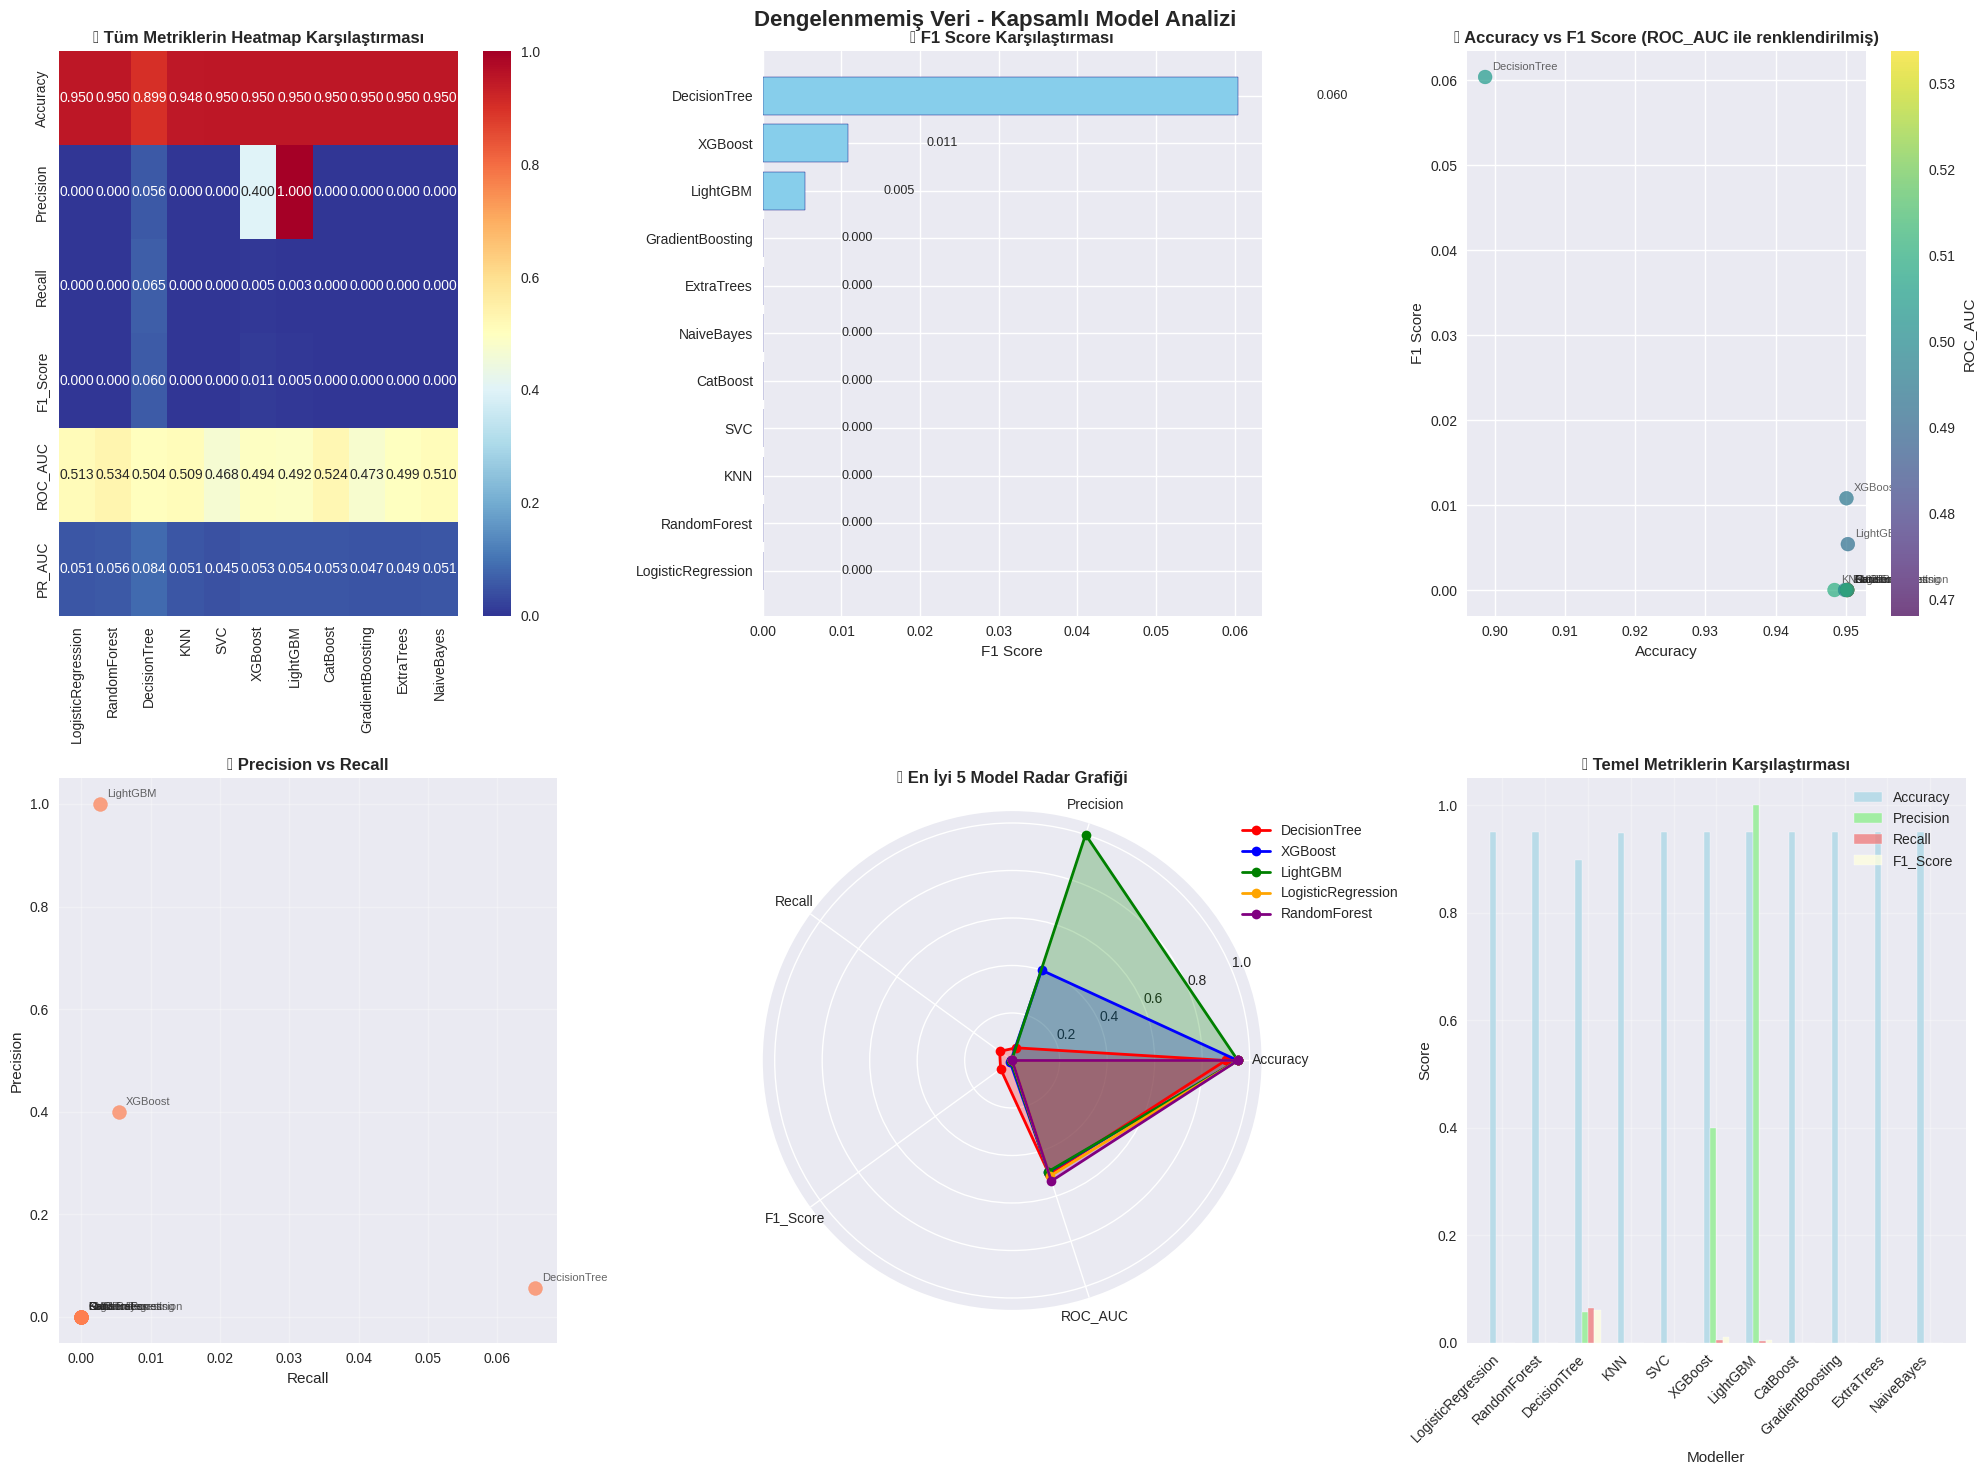

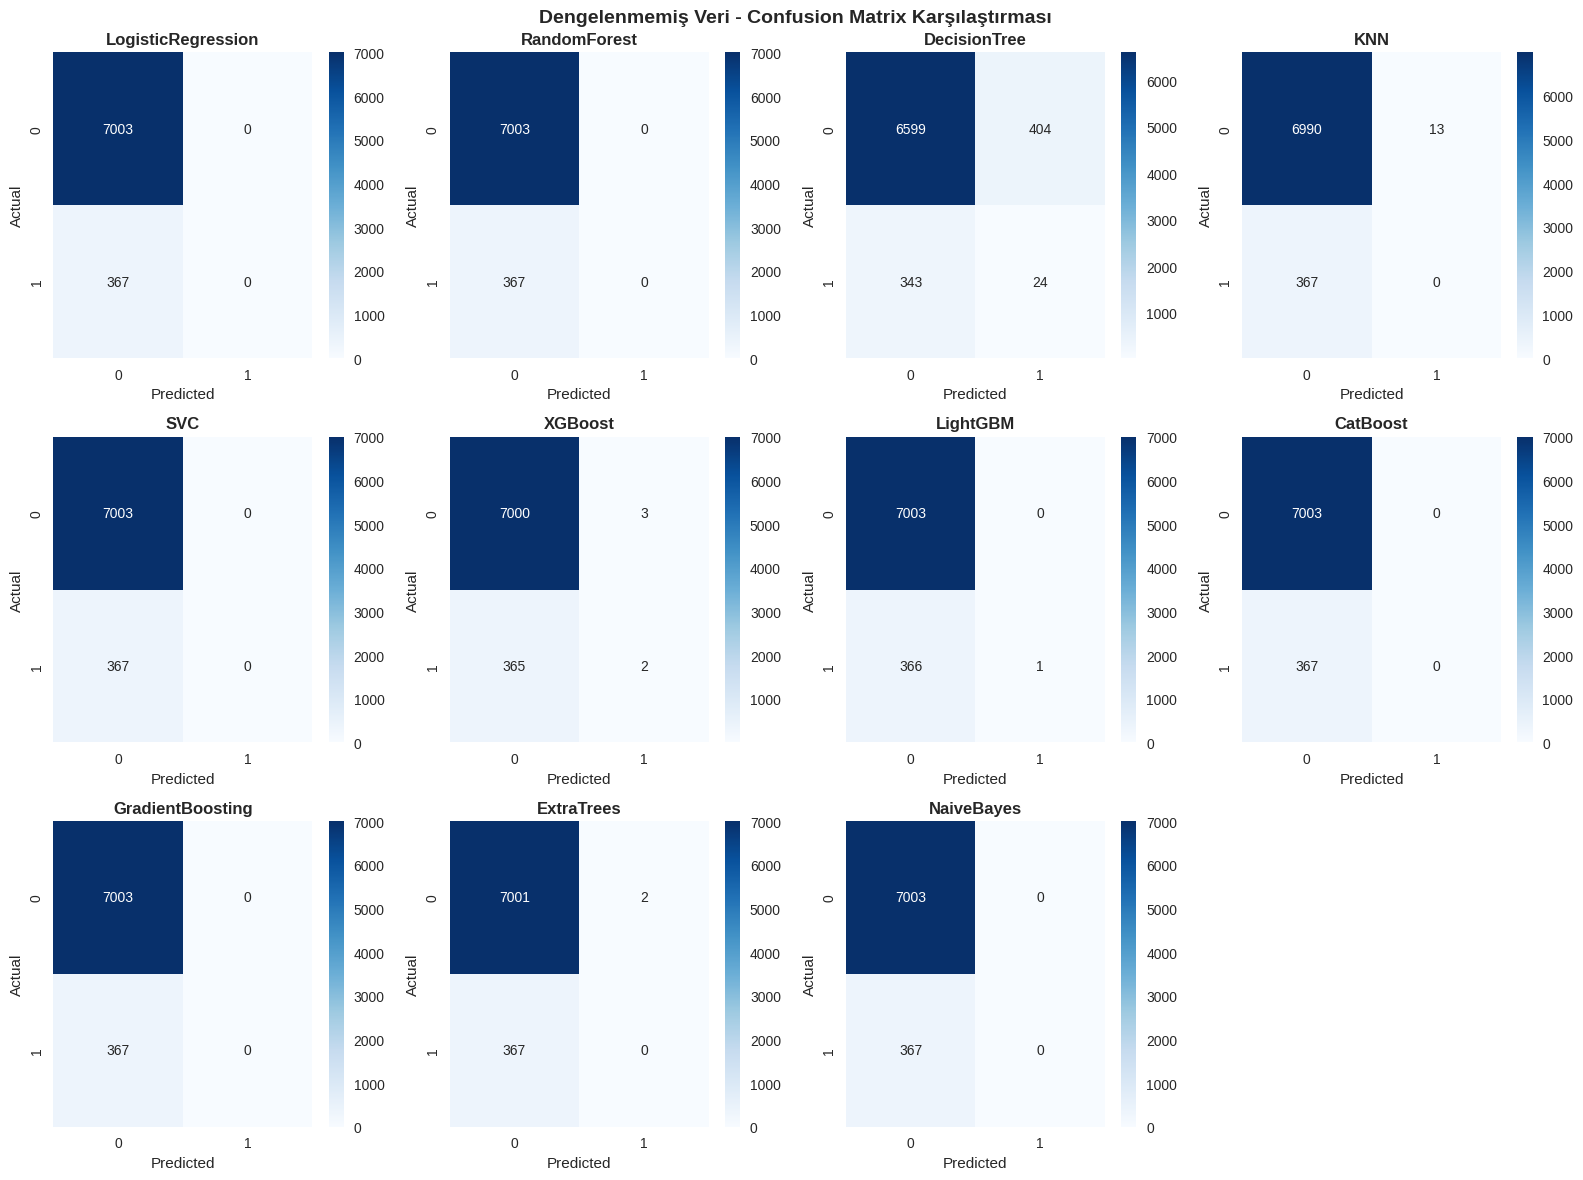


🔄 SMOTE ANALİZİ BAŞLIYOR...

🚀 SMOTE - MODEL EĞİTİMİ VE DEĞERLENDİRME

🔎 LogisticRegression eğitiliyor...
   ✅ LogisticRegression: F1=0.0848, Accuracy=0.8478, ROC_AUC=0.4951

🔎 RandomForest eğitiliyor...
   ✅ RandomForest: F1=0.0049, Accuracy=0.9452, ROC_AUC=0.4951

🔎 DecisionTree eğitiliyor...
   ✅ DecisionTree: F1=0.0500, Accuracy=0.8659, ROC_AUC=0.4892

🔎 KNN eğitiliyor...
   ✅ KNN: F1=0.0767, Accuracy=0.8138, ROC_AUC=0.4972

🔎 SVC eğitiliyor...
   ✅ SVC: F1=0.0830, Accuracy=0.7991, ROC_AUC=0.5088

🔎 XGBoost eğitiliyor...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   ✅ XGBoost: F1=0.0150, Accuracy=0.9464, ROC_AUC=0.4986

🔎 LightGBM eğitiliyor...
   ✅ LightGBM: F1=0.0104, Accuracy=0.9484, ROC_AUC=0.4821

🔎 CatBoost eğitiliyor...
   ✅ CatBoost: F1=0.0000, Accuracy=0.9498, ROC_AUC=0.4930

🔎 GradientBoosting eğitiliyor...
   ✅ GradientBoosting: F1=0.0052, Accuracy=0.9479, ROC_AUC=0.4921

🔎 ExtraTrees eğitiliyor...
   ✅ ExtraTrees: F1=0.0101, Accuracy=0.9465, ROC_AUC=0.4963

🔎 NaiveBayes eğitiliyor...
   ✅ NaiveBayes: F1=0.0792, Accuracy=0.8360, ROC_AUC=0.4870

📊 SMOTE - DETAYLI METRİK TABLOSU
             Model  Accuracy  Precision  Recall  F1_Score  Specificity  ROC_AUC  PR_AUC
LogisticRegression    0.8478     0.0605  0.1417    0.0848       0.8848   0.4951  0.0502
      RandomForest    0.9452     0.0256  0.0027    0.0049       0.9946   0.4951  0.0493
      DecisionTree    0.8659     0.0386  0.0708    0.0500       0.9076   0.4892  0.0779
               KNN    0.8138     0.0509  0.1553    0.0767       0.8484   0.4972  0.0650
               SVC    0.7

<ipython-input-17-209594235>:114: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127914 (\N{CIRCUS TENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(byt

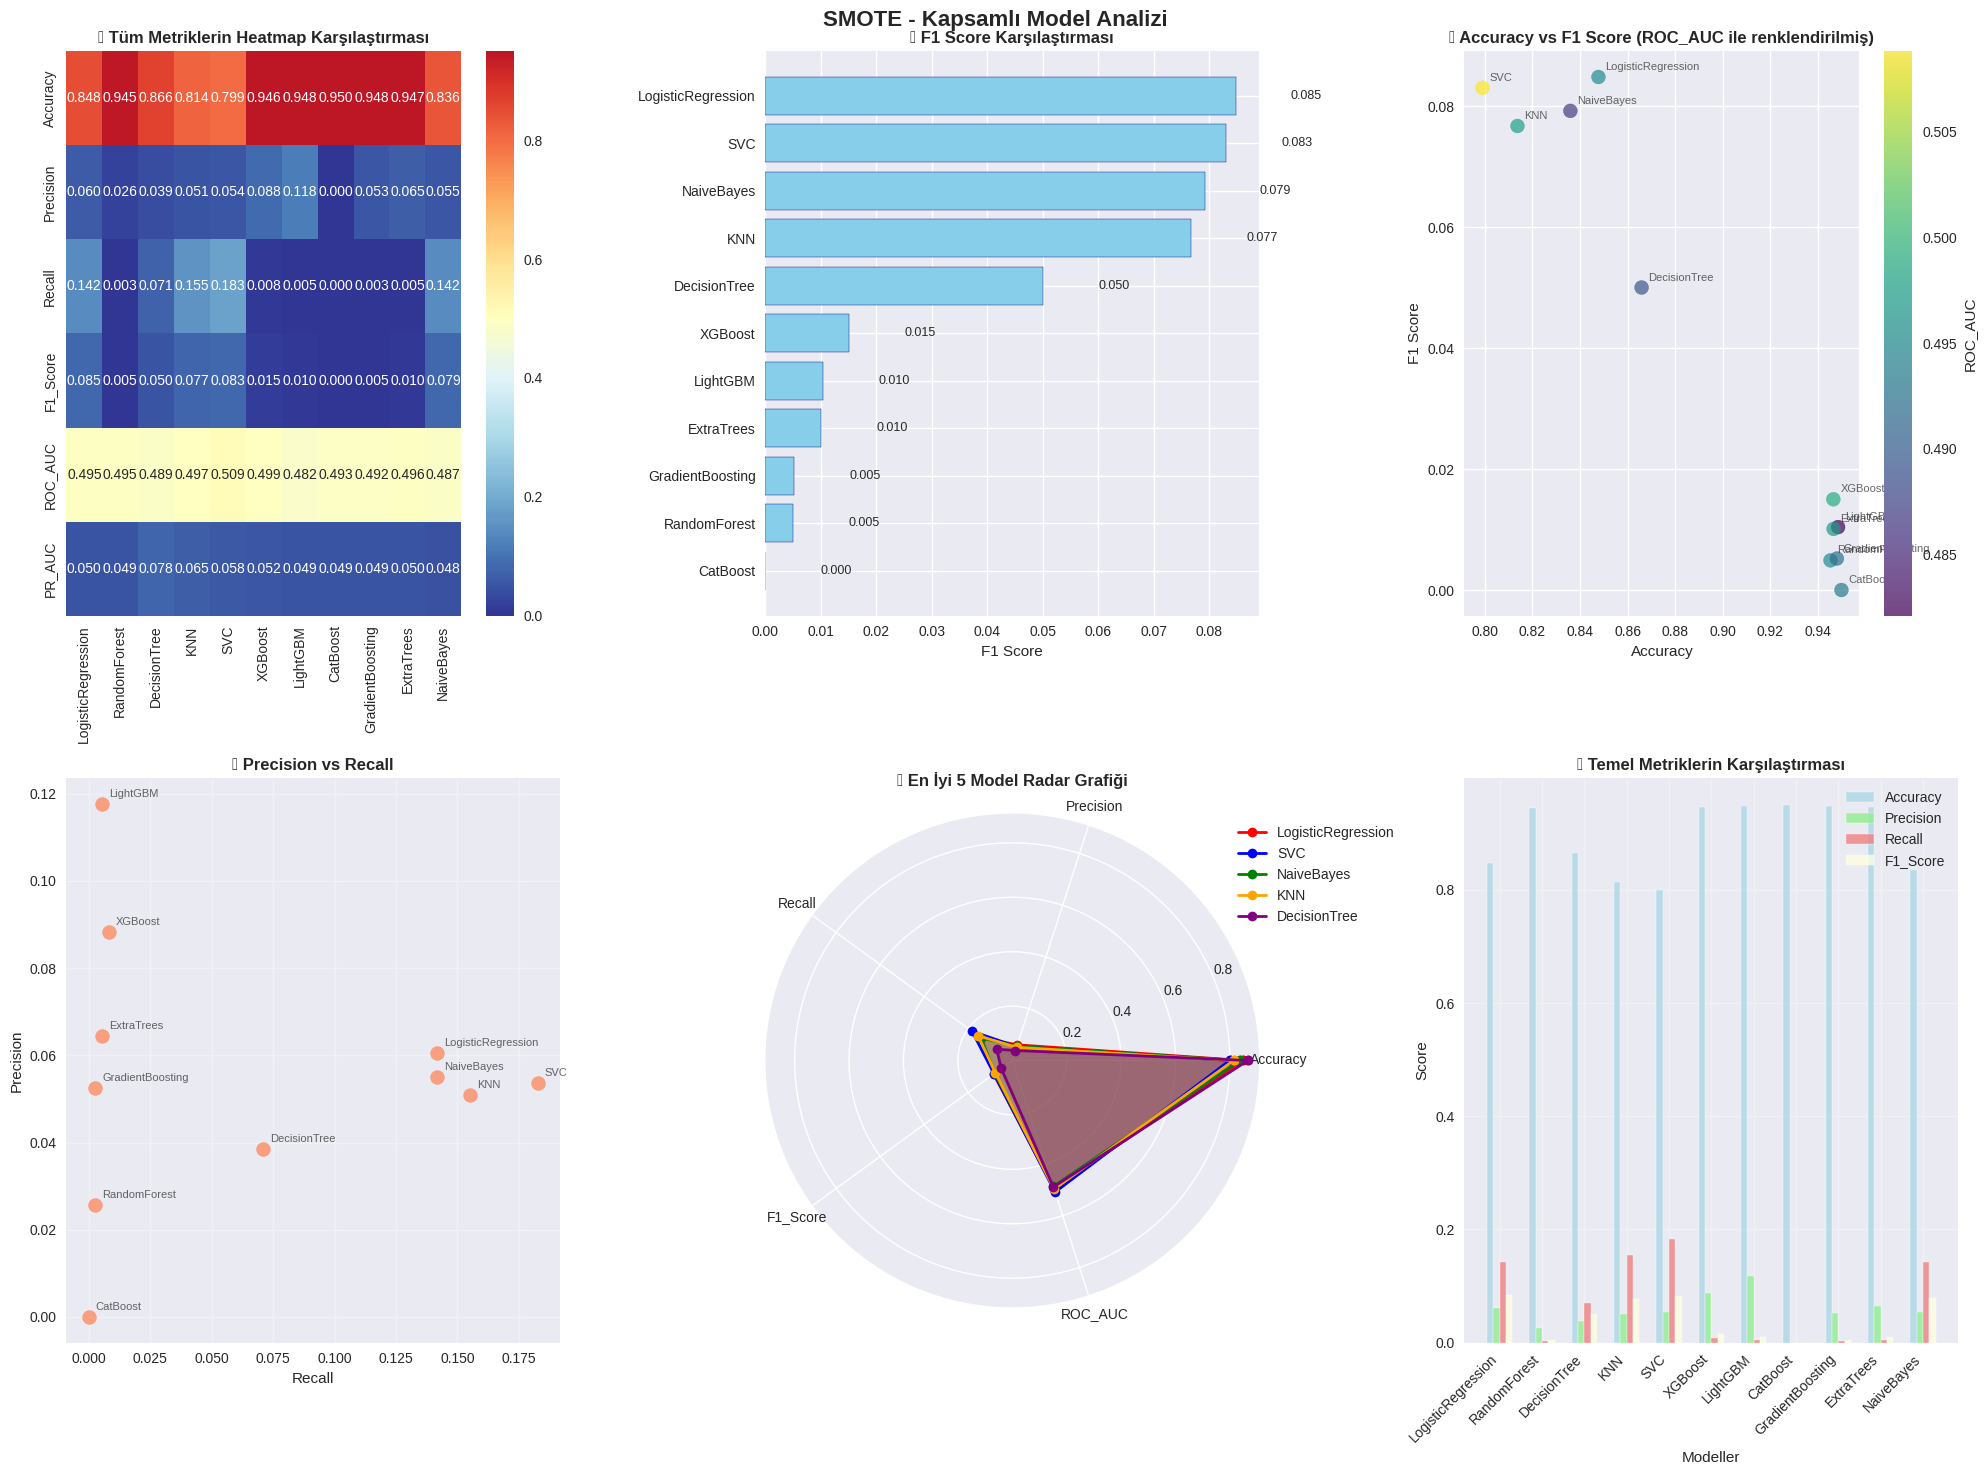

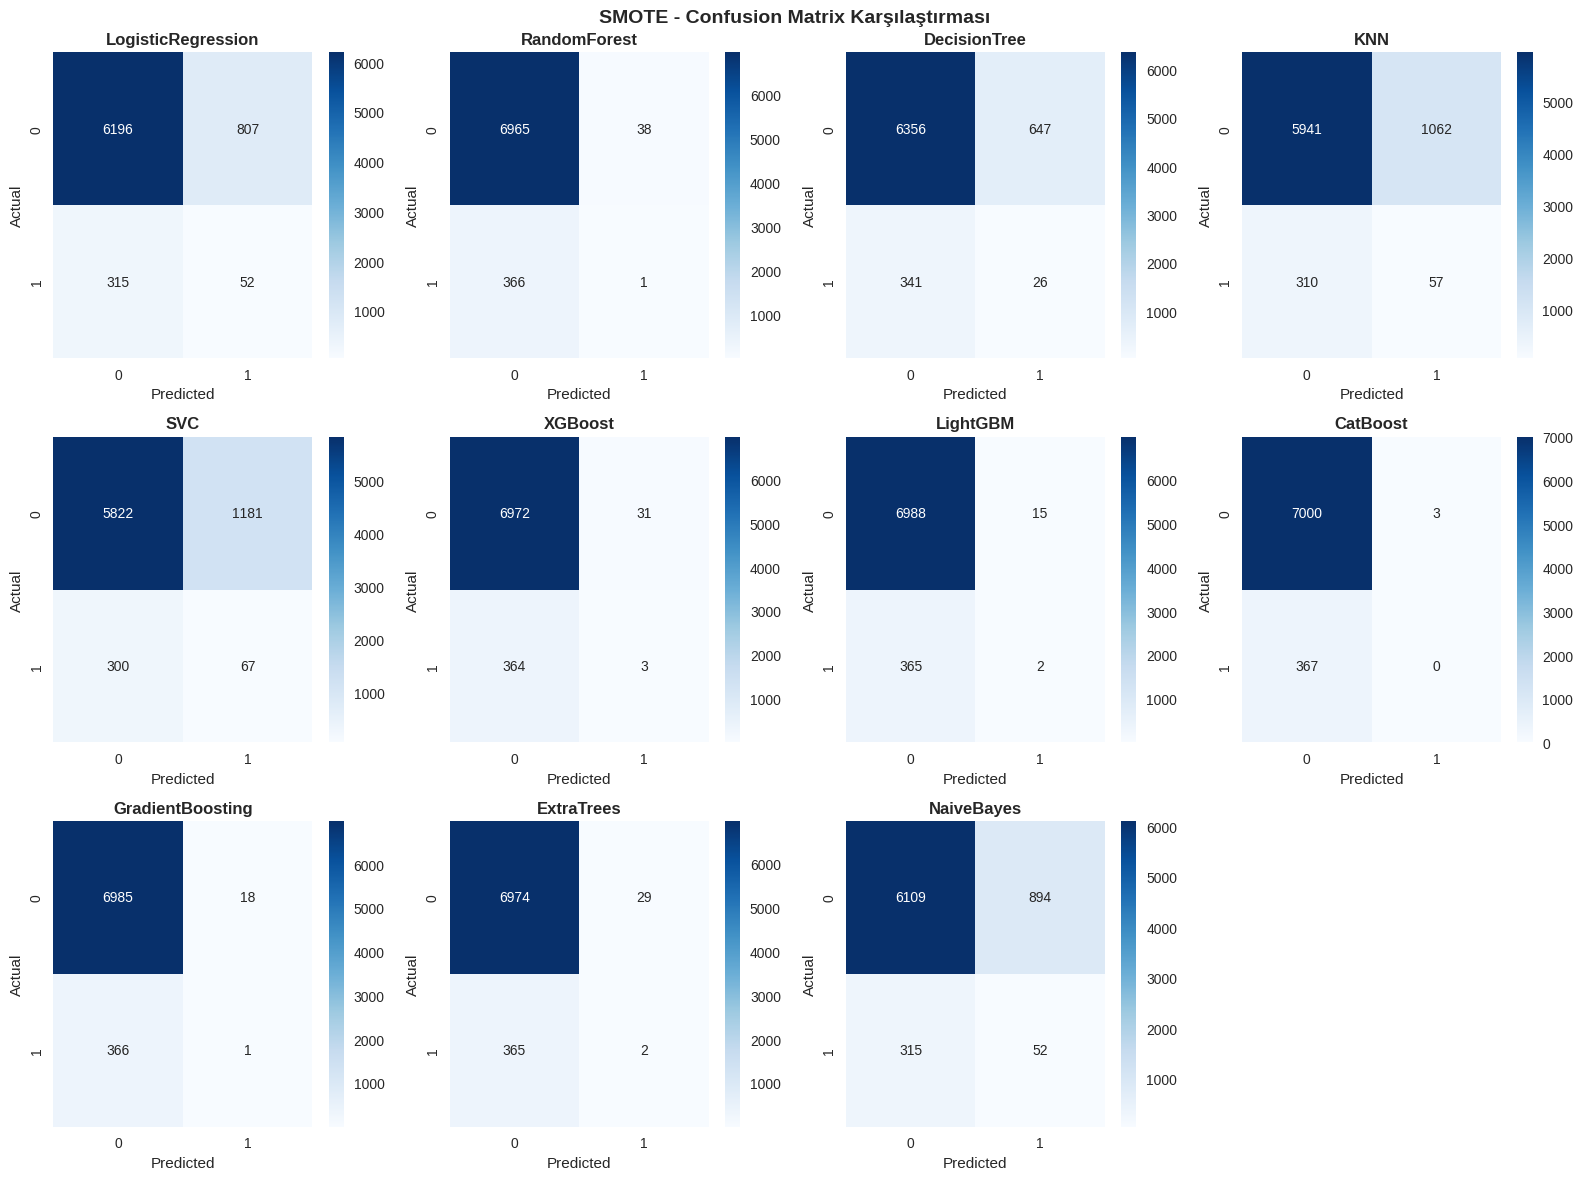


🔄 ADASYN ANALİZİ BAŞLIYOR...

🚀 ADASYN - MODEL EĞİTİMİ VE DEĞERLENDİRME

🔎 LogisticRegression eğitiliyor...
   ✅ LogisticRegression: F1=0.0845, Accuracy=0.8529, ROC_AUC=0.4937

🔎 RandomForest eğitiliyor...
   ✅ RandomForest: F1=0.0100, Accuracy=0.9464, ROC_AUC=0.4979

🔎 DecisionTree eğitiliyor...
   ✅ DecisionTree: F1=0.0626, Accuracy=0.8699, ROC_AUC=0.4990

🔎 KNN eğitiliyor...
   ✅ KNN: F1=0.0865, Accuracy=0.8167, ROC_AUC=0.5012

🔎 SVC eğitiliyor...
   ✅ SVC: F1=0.0836, Accuracy=0.8125, ROC_AUC=0.5094

🔎 XGBoost eğitiliyor...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   ✅ XGBoost: F1=0.0153, Accuracy=0.9475, ROC_AUC=0.5006

🔎 LightGBM eğitiliyor...
   ✅ LightGBM: F1=0.0000, Accuracy=0.9491, ROC_AUC=0.4923

🔎 CatBoost eğitiliyor...
   ✅ CatBoost: F1=0.0054, Accuracy=0.9501, ROC_AUC=0.4926

🔎 GradientBoosting eğitiliyor...
   ✅ GradientBoosting: F1=0.0103, Accuracy=0.9479, ROC_AUC=0.4919

🔎 ExtraTrees eğitiliyor...
   ✅ ExtraTrees: F1=0.0049, Accuracy=0.9450, ROC_AUC=0.4822

🔎 NaiveBayes eğitiliyor...
   ✅ NaiveBayes: F1=0.0798, Accuracy=0.8372, ROC_AUC=0.4880

📊 ADASYN - DETAYLI METRİK TABLOSU
             Model  Accuracy  Precision  Recall  F1_Score  Specificity  ROC_AUC  PR_AUC
LogisticRegression    0.8529     0.0612  0.1362    0.0845       0.8905   0.4937  0.0495
      RandomForest    0.9464     0.0625  0.0054    0.0100       0.9957   0.4979  0.0491
      DecisionTree    0.8699     0.0488  0.0872    0.0626       0.9109   0.4990  0.0907
               KNN    0.8167     0.0576  0.1744    0.0865       0.8503   0.5012  0.0673
               SVC    0.

<ipython-input-17-209594235>:114: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127914 (\N{CIRCUS TENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(byt

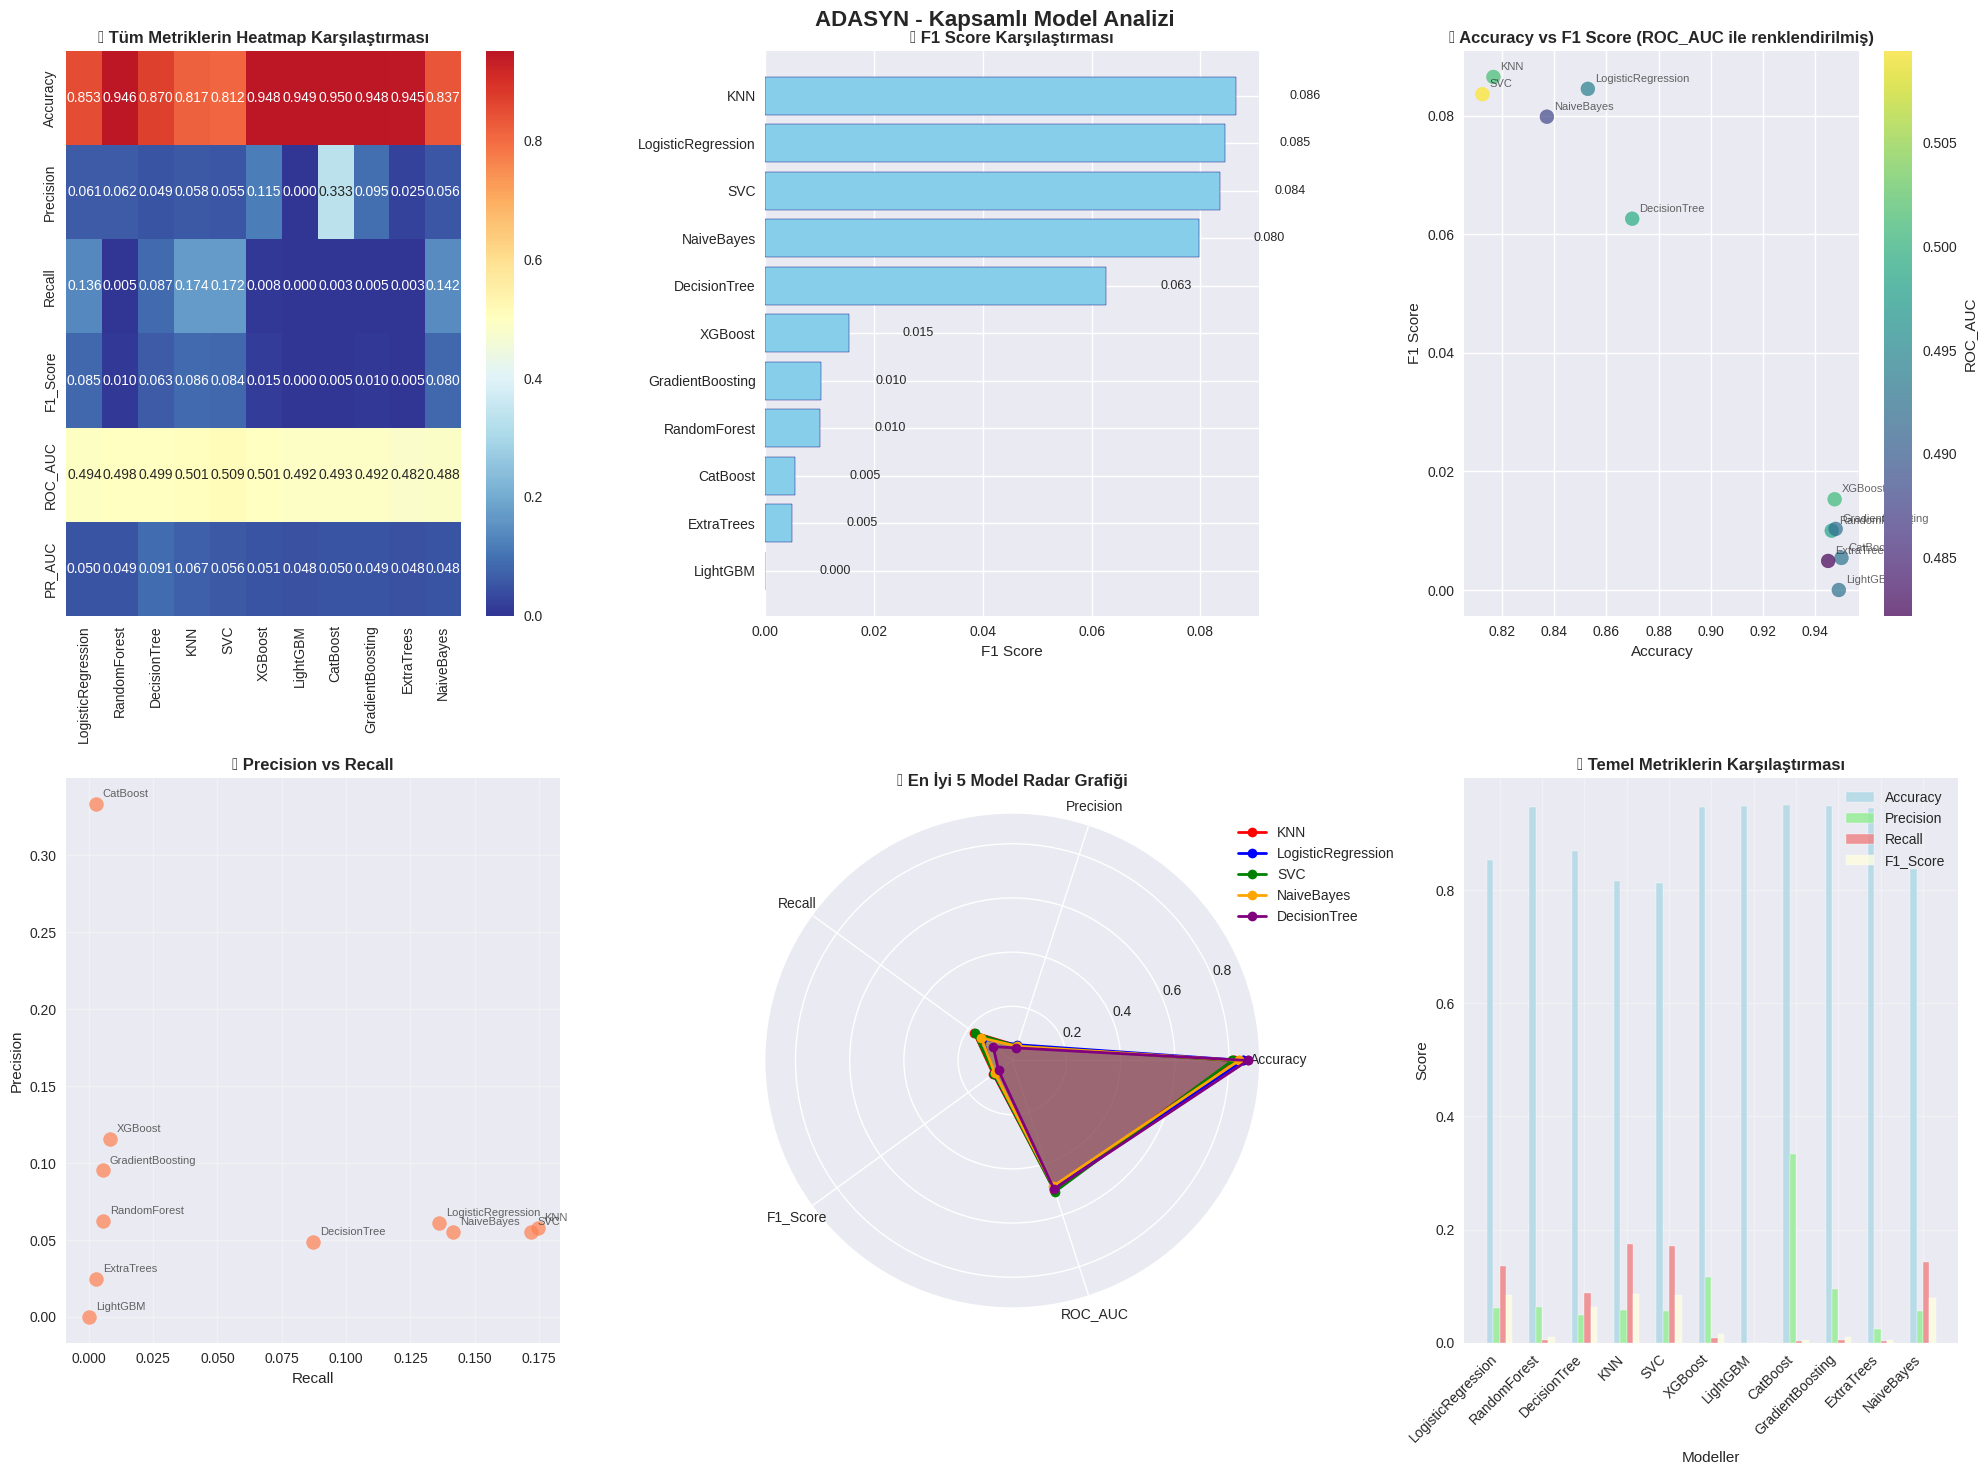

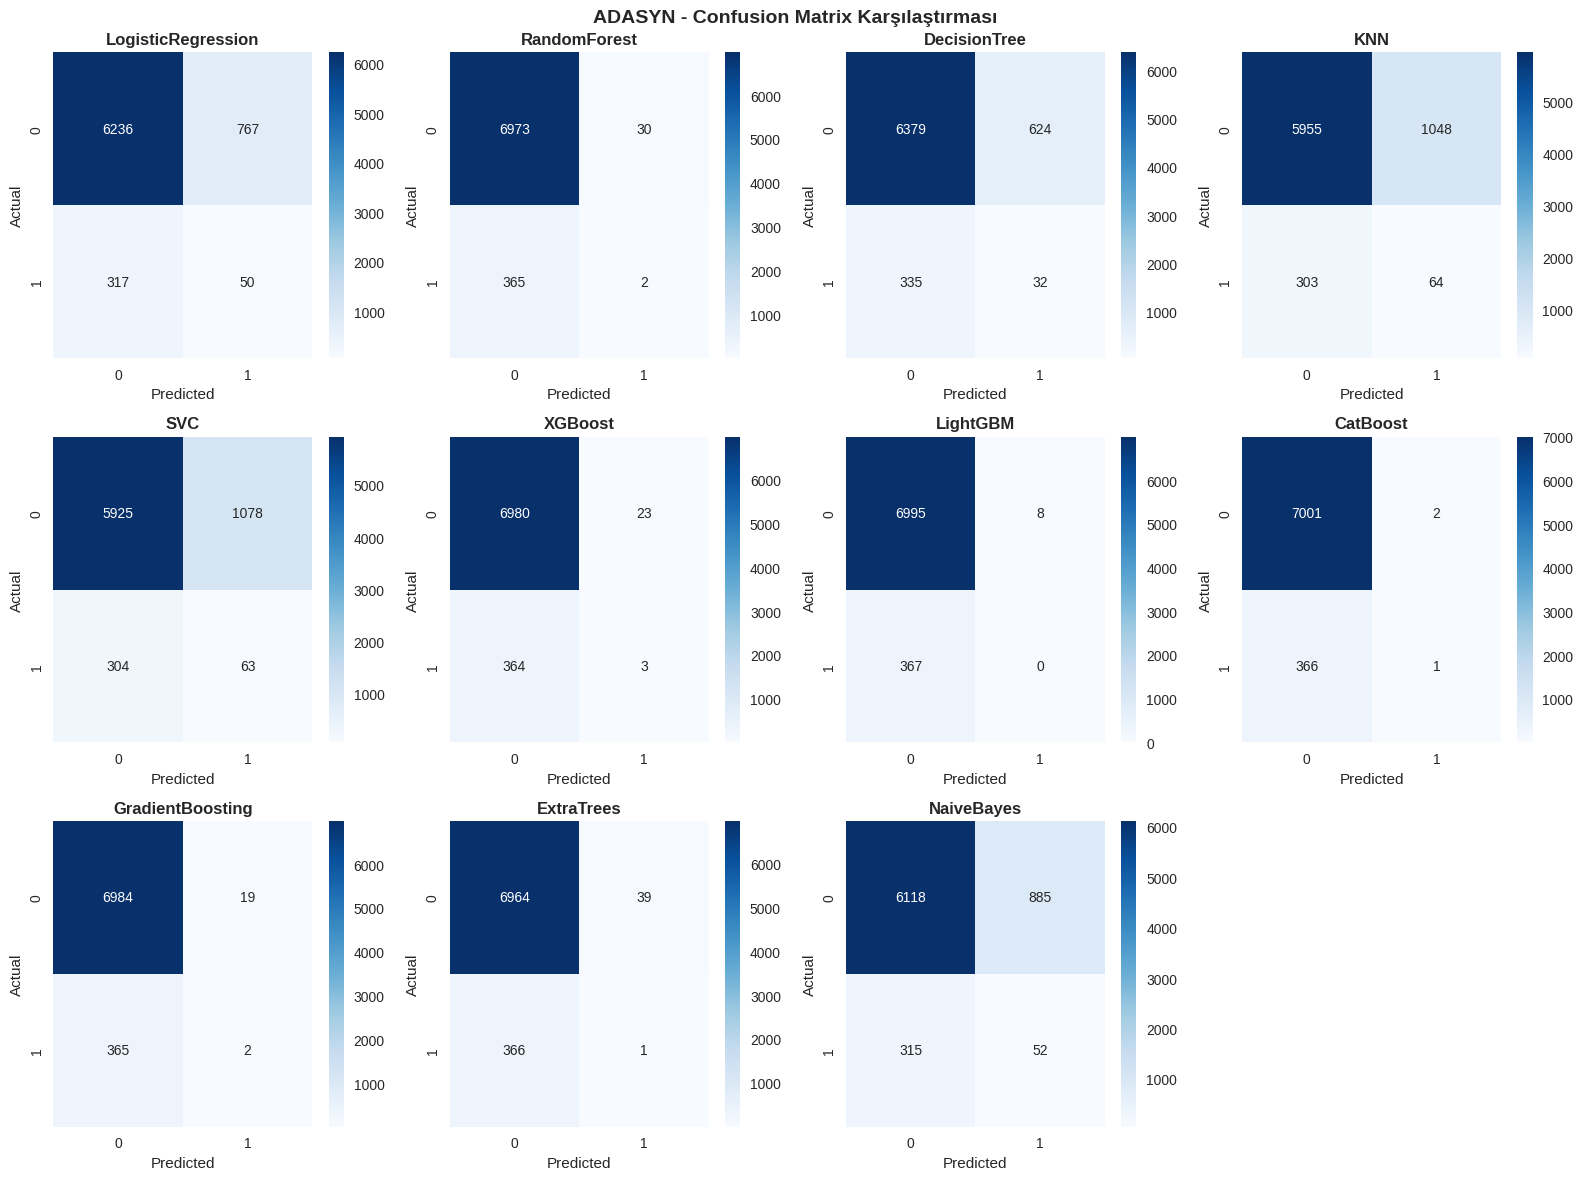


🔄 NEARMISS ANALİZİ BAŞLIYOR...

🚀 NearMiss - MODEL EĞİTİMİ VE DEĞERLENDİRME

🔎 LogisticRegression eğitiliyor...
   ✅ LogisticRegression: F1=0.0945, Accuracy=0.3577, ROC_AUC=0.5147

🔎 RandomForest eğitiliyor...
   ✅ RandomForest: F1=0.0976, Accuracy=0.1992, ROC_AUC=0.5240

🔎 DecisionTree eğitiliyor...
   ✅ DecisionTree: F1=0.0926, Accuracy=0.3115, ROC_AUC=0.4983

🔎 KNN eğitiliyor...
   ✅ KNN: F1=0.0914, Accuracy=0.2692, ROC_AUC=0.4994

🔎 SVC eğitiliyor...
   ✅ SVC: F1=0.0996, Accuracy=0.4113, ROC_AUC=0.5309

🔎 XGBoost eğitiliyor...
   ✅ XGBoost: F1=0.0945, Accuracy=0.2457, ROC_AUC=0.5216

🔎 LightGBM eğitiliyor...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


   ✅ LightGBM: F1=0.0968, Accuracy=0.2376, ROC_AUC=0.5192

🔎 CatBoost eğitiliyor...
   ✅ CatBoost: F1=0.0986, Accuracy=0.2214, ROC_AUC=0.5238

🔎 GradientBoosting eğitiliyor...
   ✅ GradientBoosting: F1=0.0978, Accuracy=0.2315, ROC_AUC=0.5208

🔎 ExtraTrees eğitiliyor...
   ✅ ExtraTrees: F1=0.0968, Accuracy=0.2431, ROC_AUC=0.5359

🔎 NaiveBayes eğitiliyor...
   ✅ NaiveBayes: F1=0.0948, Accuracy=0.3681, ROC_AUC=0.5282

📊 NearMiss - DETAYLI METRİK TABLOSU
             Model  Accuracy  Precision  Recall  F1_Score  Specificity  ROC_AUC  PR_AUC
LogisticRegression    0.3577     0.0508  0.6730    0.0945       0.3411   0.5147  0.0539
      RandomForest    0.1992     0.0517  0.8692    0.0976       0.1641   0.5240  0.0520
      DecisionTree    0.3115     0.0496  0.7057    0.0926       0.2909   0.4983  0.3850
               KNN    0.2692     0.0487  0.7384    0.0914       0.2446   0.4994  0.2221
               SVC    0.4113     0.0539  0.6540    0.0996       0.3985   0.5309  0.0532
           XGBoos

<ipython-input-17-209594235>:114: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 127914 (\N{CIRCUS TENT}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128376 (\N{SPIDER WEB}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-17-209594235>:114: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(byt

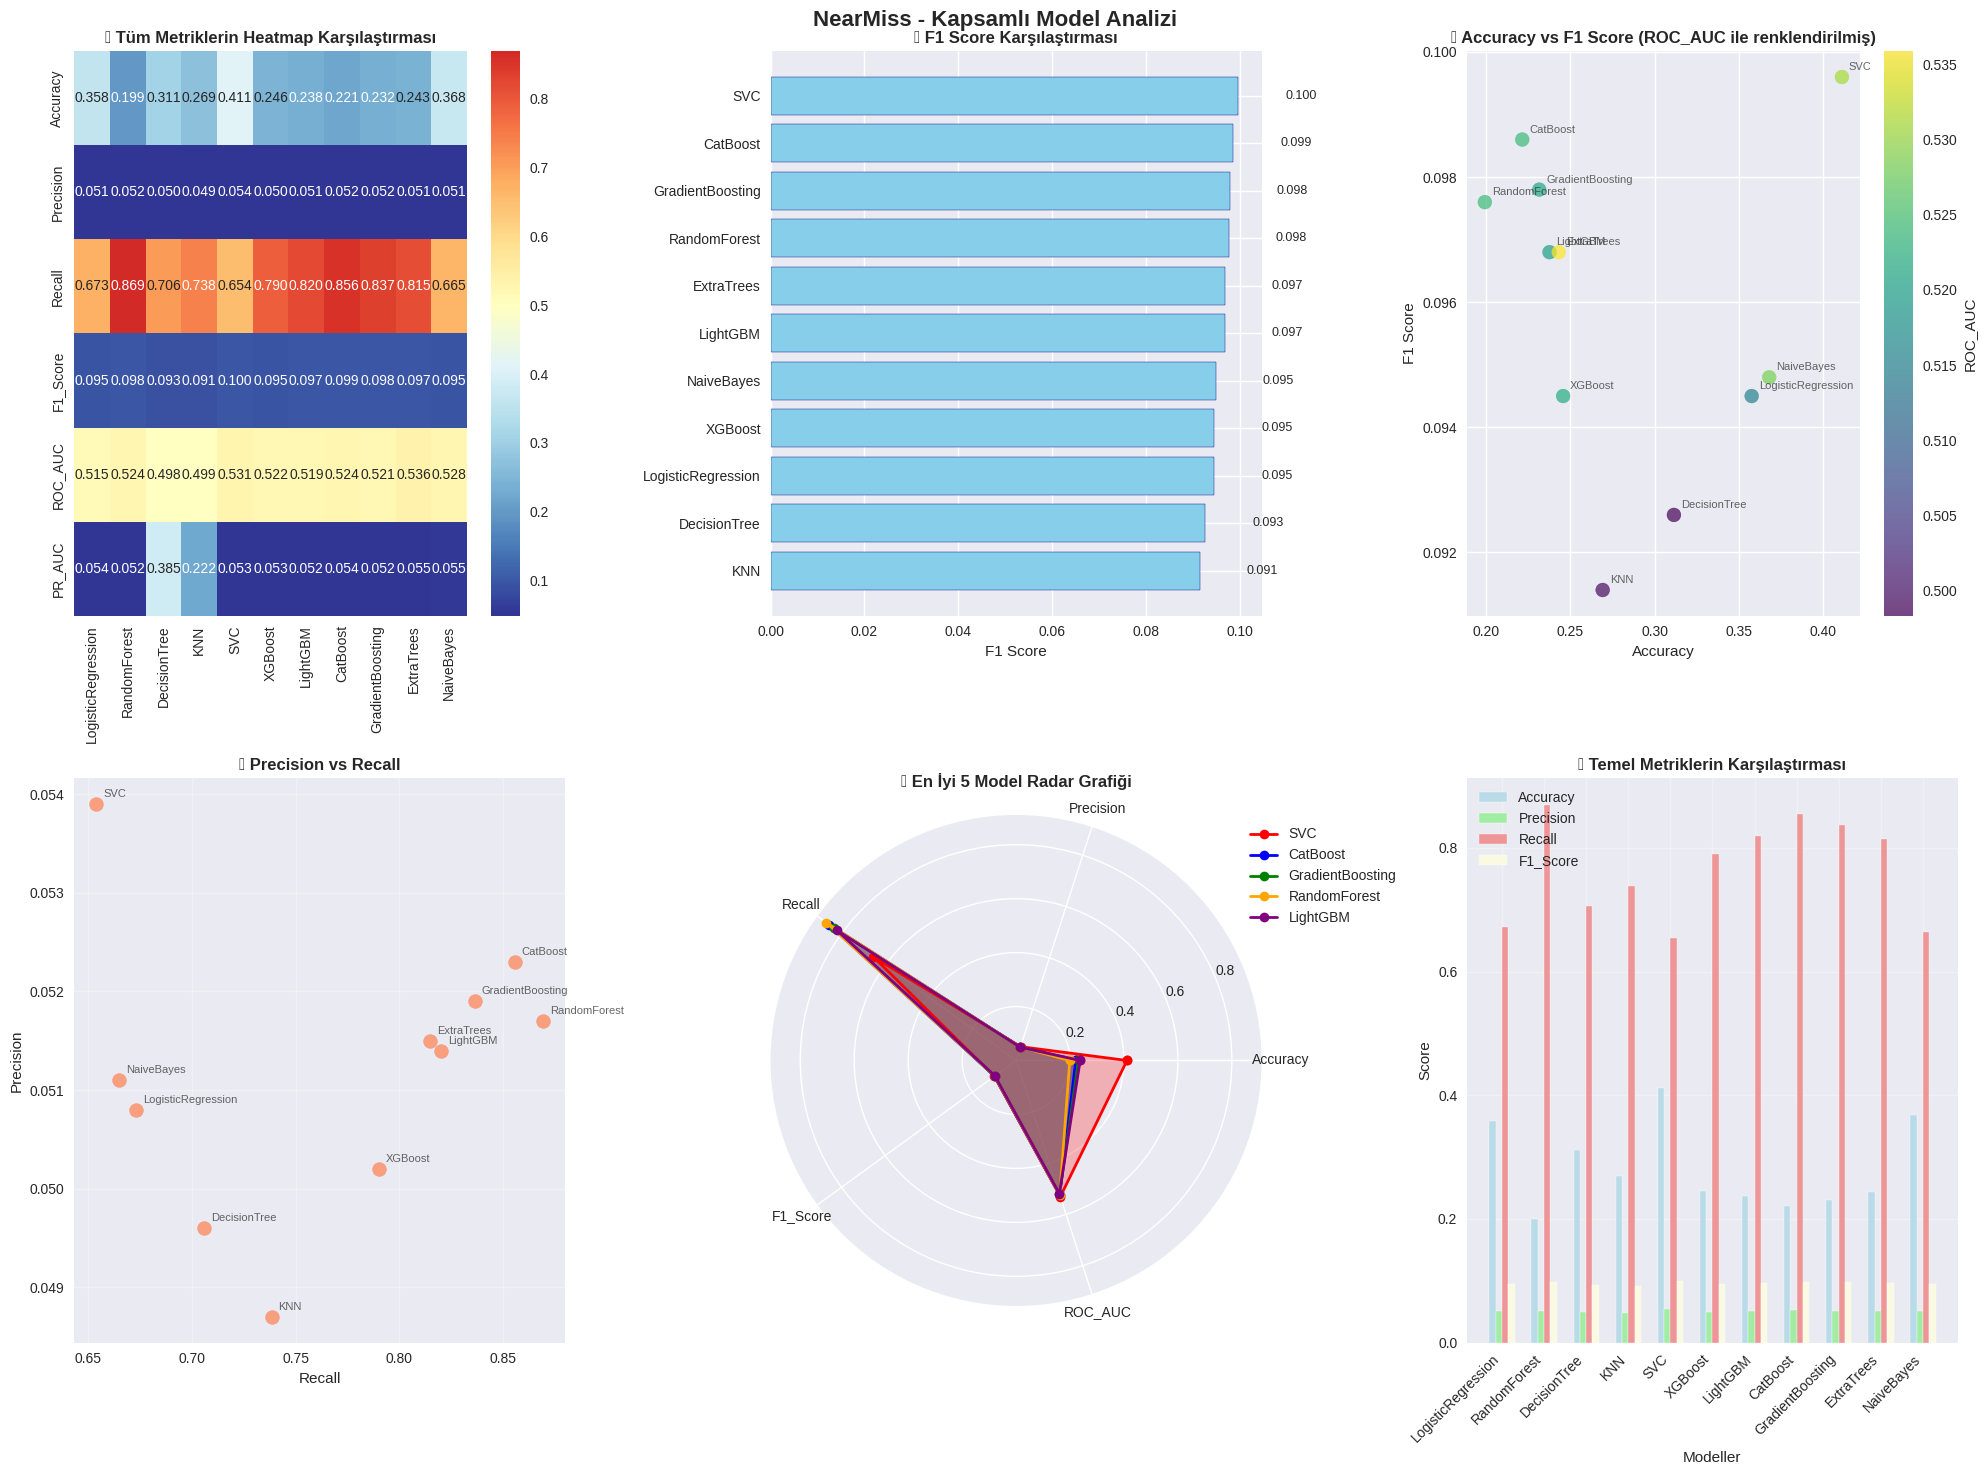

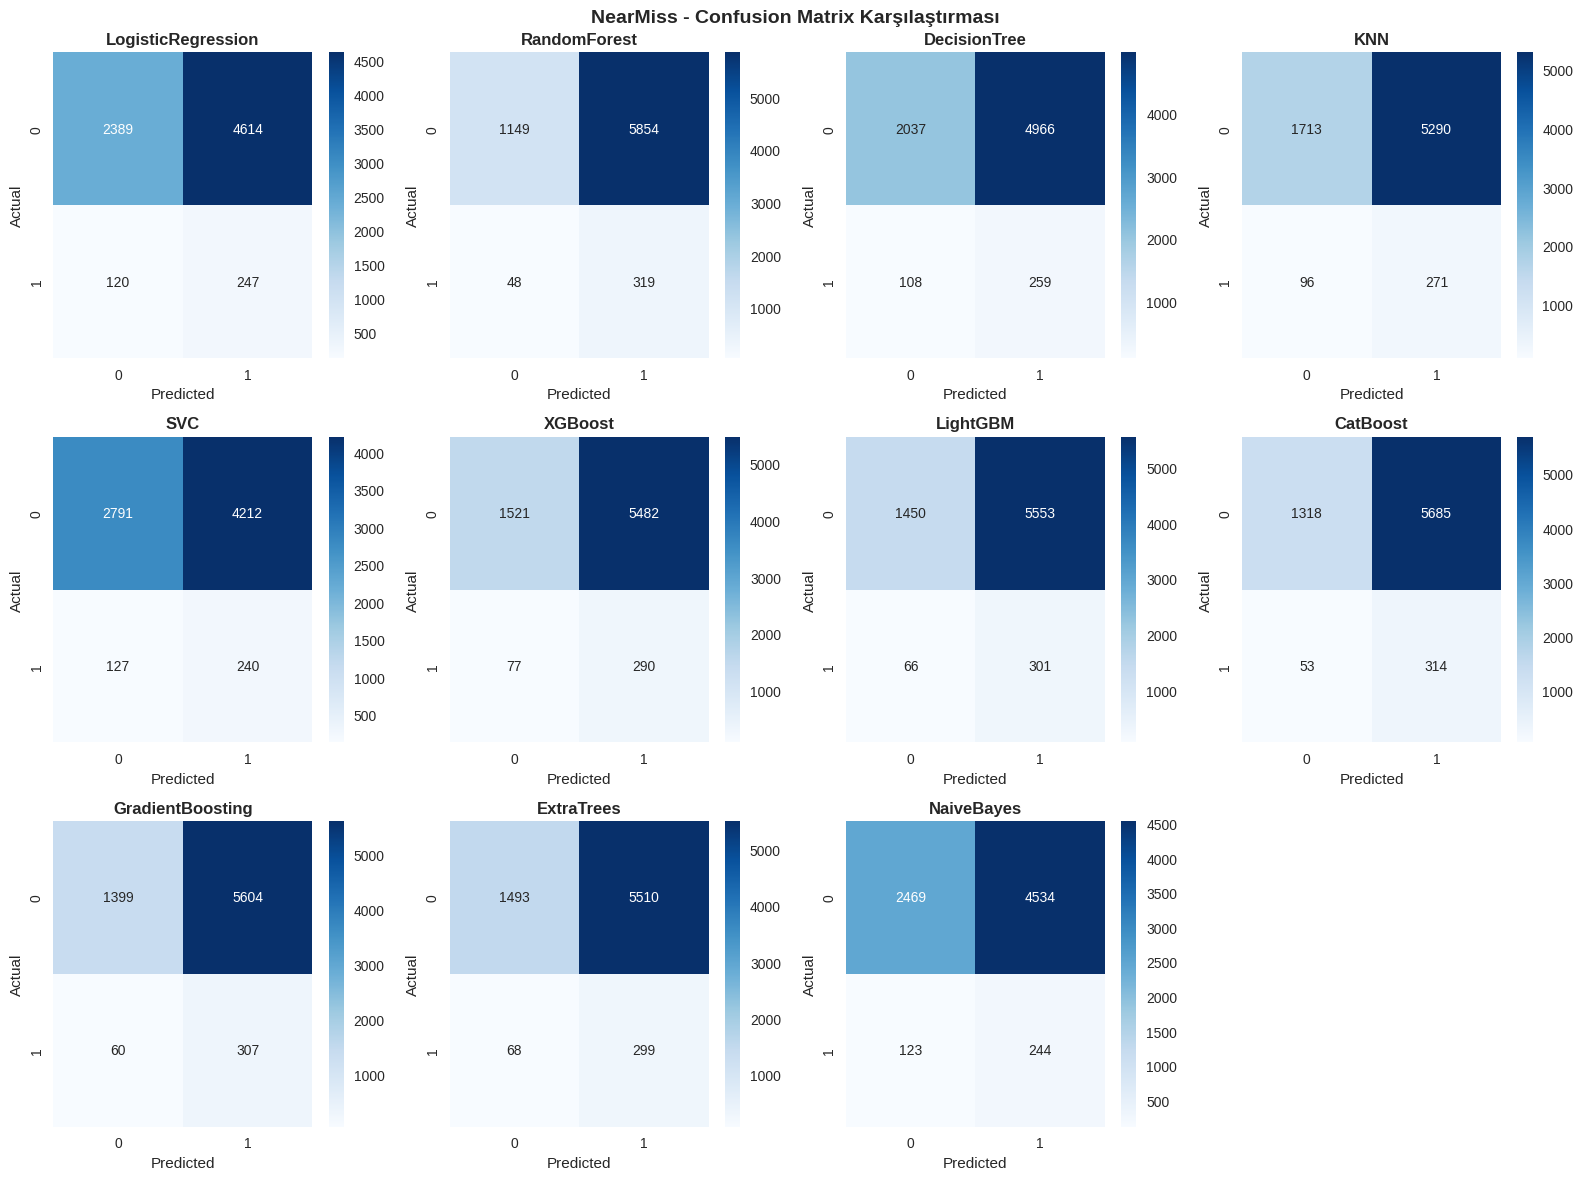


🔄 GENEL KARŞILAŞTIRMA BAŞLIYOR...

🔥 TÜM YÖNTEMLERİN KAPSAMLI KARŞILAŞTIRMASI

🏆 EN İYİ PERFORMANSLAR:
--------------------------------------------------------------------------------
Accuracy    : Dengelenmemiş   - LightGBM           (0.9503)
Precision   : Dengelenmemiş   - LightGBM           (1.0000)
Recall      : NearMiss        - RandomForest       (0.8692)
F1_Score    : NearMiss        - SVC                (0.0996)
ROC_AUC     : NearMiss        - ExtraTrees         (0.5359)
PR_AUC      : NearMiss        - DecisionTree       (0.3850)

📊 YÖNTEM BAZINDA ORTALAMA PERFORMANSLAR:
--------------------------------------------------------------------------------
               Accuracy  Precision  Recall  F1_Score  ROC_AUC  PR_AUC
Method                                                               
ADASYN           0.8977     0.0827  0.0669    0.0403   0.4953  0.0551
Dengelenmemiş    0.9453     0.1324  0.0067    0.0070   0.5019  0.0541
NearMiss         0.2815     0.0512  0.7657    0.0959

/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) Liberation Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/IPython/core

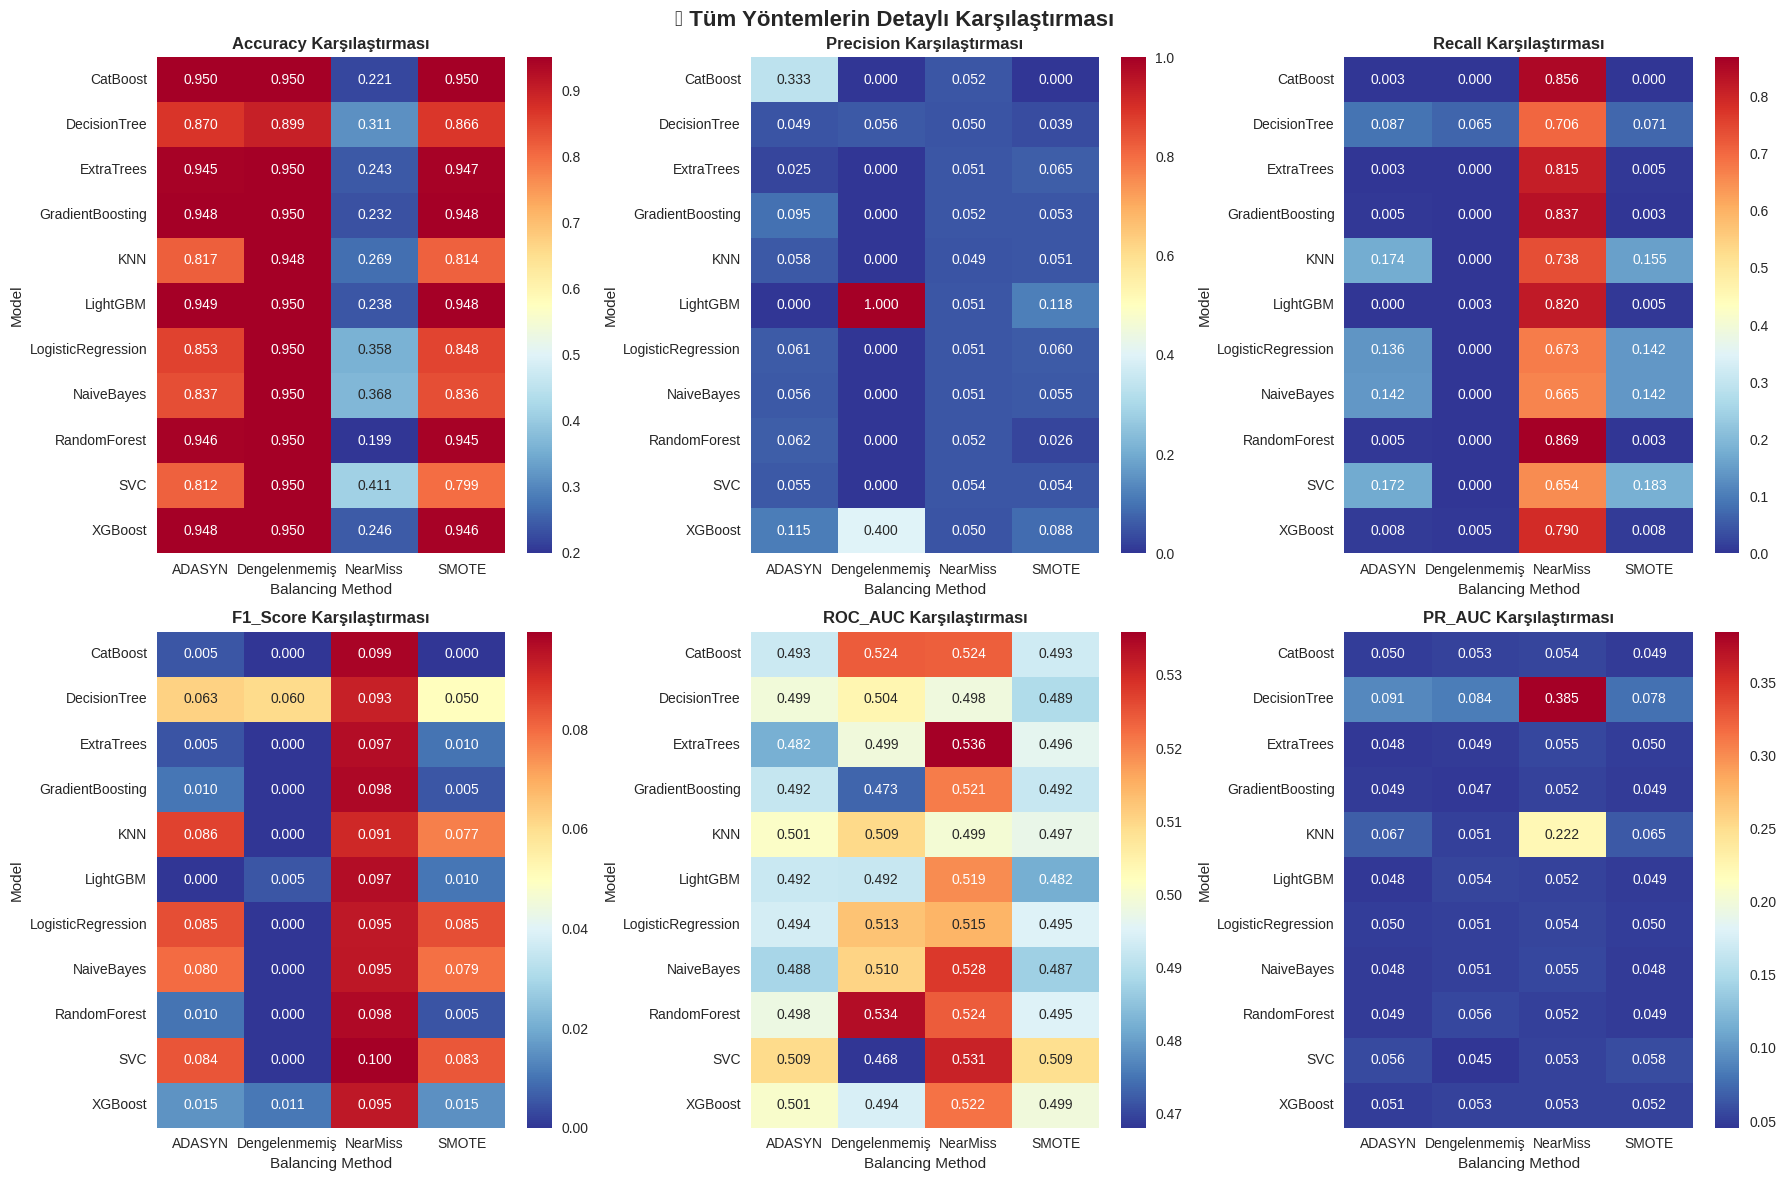


🎯 HER METRİK İÇİN EN İYİ MODEL-YÖNTEM KOMBINASYONLARI:
------------------------------------------------------------------------------------------

Accuracy Top 3:
  1. Dengelenmemiş   - LightGBM           (0.9503)
  2. Dengelenmemiş   - LogisticRegression (0.9502)
  3. Dengelenmemiş   - RandomForest       (0.9502)

Precision Top 3:
  1. Dengelenmemiş   - LightGBM           (1.0000)
  2. Dengelenmemiş   - XGBoost            (0.4000)
  3. ADASYN          - CatBoost           (0.3333)

Recall Top 3:
  1. NearMiss        - RandomForest       (0.8692)
  2. NearMiss        - CatBoost           (0.8556)
  3. NearMiss        - GradientBoosting   (0.8365)

F1_Score Top 3:
  1. NearMiss        - SVC                (0.0996)
  2. NearMiss        - CatBoost           (0.0986)
  3. NearMiss        - GradientBoosting   (0.0978)

ROC_AUC Top 3:
  1. NearMiss        - ExtraTrees         (0.5359)
  2. Dengelenmemiş   - RandomForest       (0.5338)
  3. NearMiss        - SVC                (0.5309)

PR_A

In [20]:
results_dict, final_comparison = run_comprehensive_evaluation(
    X_train, y_train, X_test, y_test,
    X_smote, y_smote, X_adasyn, y_adasyn,
    X_nearmiss, y_nearmiss
)
